In [1]:
#Imports
import numpy
import matplotlib as mpl
import pylab
import scipy.stats
%matplotlib inline

#Plot formatting stuff
font = {'family' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc("savefig", dpi=400)

In [2]:
#The classic hbar c
LConv=197.*10**-9

In [3]:

#Energy resolution
Eres=lambda mi,mh: mh**2/(2*mi)


OscProb3p1=lambda L,E,dm2,mix:mix*numpy.sin((1.27*dm2*L/E)*1e6)**2



# Load MB Data

/Users/jonesb/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


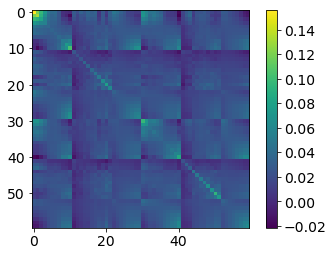

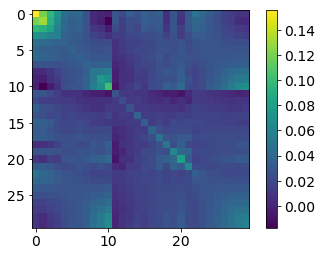

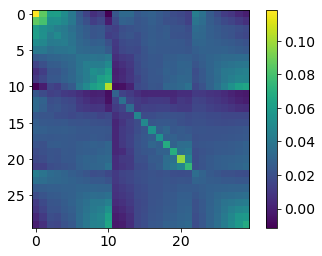

In [6]:
#Load MiniBooNE data
MBBinEdges=numpy.loadtxt("MBData/miniboone_binboundaries_nue_lowe.txt")

MBCounts=numpy.loadtxt("MBData/miniboone_nuedata_lowe.txt")
MBBackground=numpy.loadtxt("MBData/miniboone_nuebgr_lowe.txt")
MBSimEvents=numpy.loadtxt("MBData/miniboone_numunuefullosc_ntuple.txt")
MBMuons=numpy.loadtxt("MBData/miniboone_numudata.txt")
MBMuonPrediction=numpy.loadtxt("MBData/miniboone_numu.txt")

MBCounts_an=numpy.loadtxt("MBData/miniboone_nuebardata_lowe.txt")
MBBackground_an=numpy.loadtxt("MBData/miniboone_nuebarbgr_lowe.txt")
MBSimEvents_an=numpy.loadtxt("MBData/miniboone_numubarnuebarfullosc_ntuple.txt")
MBMuons_an=numpy.loadtxt("MBData/miniboone_numubardata.txt")
MBMuonPrediction_an=numpy.loadtxt("MBData/miniboone_numubar.txt")

MBCovNu= numpy.loadtxt("MBData/miniboone_full_fractcovmatrix_nu_lowe.txt")
MBCovNu_an= numpy.loadtxt("MBData/miniboone_full_fractcovmatrix_nubar_lowe.txt")
MBCovCombined = numpy.loadtxt("MBData/miniboone_full_fractcovmatrix_combined_lowe.txt")

MBTransmutedNu=numpy.histogram(MBSimEvents[:,0],weights=MBSimEvents[:,3]/float(len(MBSimEvents)),bins=MBBinEdges)[0]
MBTransmutedNu_an=numpy.histogram(MBSimEvents_an[:,0],weights=MBSimEvents_an[:,3]/float(len(MBSimEvents_an)),bins=MBBinEdges)[0]



pylab.imshow(MBCovCombined)
pylab.colorbar()
pylab.show()
pylab.imshow(MBCovNu)
pylab.colorbar()
pylab.show()
pylab.imshow(MBCovNu_an)
pylab.colorbar()
pylab.show()

# Drawing and Chi2 Functions

In [161]:
def DrawMBOscillated3p1(dm2,mix,BinEdge,MBSim,MBBack,MBData,FileName=""):
    NewWeight=[]
    for i in MBSim:
        NewWeight.append(OscProb3p1(i[2]/1e2,i[1]*1e6,dm2,mix))
    BGCenters=(BinEdge[:-1]+BinEdge[1:])/2
    HistX=  [BGCenters,MBSim[:,0]]
    HistWts=[MBBack,MBSim[:,3]*numpy.array(NewWeight)/float(len(MBSim))]
    pylab.figure(figsize=(6,6),dpi=400)
    pylab.hist(HistX,weights=HistWts,bins=BinEdge,stacked=True,rwidth=1,alpha=0.5,label=["MB Background","Best-Fit Excess"])

    pylab.errorbar((BinEdge[:-1]+BinEdge[1:])/2,MBData,yerr=pow(MBData,0.5),xerr=(BinEdge[:-1]-BinEdge[1:])/2,color='black',linewidth=2,label='Data',linestyle='none')
    pylab.legend(loc='upper right')
    pylab.xlim(0,2000)
    pylab.xlabel("Energy / MeV")
    pylab.ylabel("Count / MeV")
    pylab.tight_layout()
    if(FileName!=""):
        pylab.savefig(FileName,dpi=200,bbox_inches=0)
    pylab.show()
    

#Recipe from https://www-boone.fnal.gov/for_physicists/data_release/lowe/miniboone_may09publicdata_instructions.pdf
def Chi2MBOscillated3p1Nu(dm2,mix):
    NewWeight=[]
    for i in MBSimEvents:
        NewWeight.append(OscProb3p1(i[2]/1e2,i[1]*1e6,dm2,mix))
    signal=numpy.histogram(MBSimEvents[:,0],weights=MBSimEvents[:,3]*numpy.array(NewWeight)/float(len(MBSimEvents)),bins=MBBinEdges)[0]
    
    MBDataFit2by2       = numpy.concatenate([MBCounts,MBMuons])
    MBPredictionFit2by2 = numpy.concatenate([MBBackground+signal,MBMuonPrediction])
    MBResidual2by2      = MBDataFit2by2-MBPredictionFit2by2

    P3by3 = numpy.concatenate([signal,MBBackground,MBMuonPrediction])
    from numpy import linalg 
    TheCov=numpy.zeros_like(MBCovNu)
    for i in range(MBCovNu.shape[0]):
        for j in range(MBCovNu.shape[1]):
            TheCov[i,j] = MBCovNu[i,j] * P3by3[i]*P3by3[j]
    for i in range(0,len(signal)):
        TheCov[i,i]+=signal[i]

    Block11 = TheCov[0:11,0:11]+TheCov[11:22,11:22]+TheCov[11:22,0:11]+TheCov[0:11,11:22]
    Block22 = TheCov[22:30,22:30]
    Block12 = TheCov[0:11,22:30]+TheCov[11:22,22:30]
    Block21 = TheCov[22:30,0:11]+TheCov[22:30,11:22]

    CovMatrix2by2=numpy.block( [    [Block11, Block12],
                                    [Block21, Block22]  ]   )

    Covinv2by2 = linalg.inv(CovMatrix2by2)

    chi2 = numpy.dot(MBResidual2by2,numpy.dot(Covinv2by2,MBResidual2by2))
    
    return float(chi2)


def Chi2MBOscillated3p1NuBar(dm2,mix):
    NewWeight=[]
    for i in MBSimEvents_an:
        NewWeight.append(OscProb3p1(i[2]/1e2,i[1]*1e6,dm2,mix))
    signal=numpy.histogram(MBSimEvents_an[:,0],weights=MBSimEvents_an[:,3]*numpy.array(NewWeight)/float(len(MBSimEvents_an)),bins=MBBinEdges)[0]
#    print signal
    MBDataFit2by2       = numpy.concatenate([MBCounts_an,MBMuons_an])
    MBPredictionFit2by2 = numpy.concatenate([MBBackground_an+signal,MBMuonPrediction_an])
    MBResidual2by2      = MBDataFit2by2-MBPredictionFit2by2

#    P3by3 = numpy.concatenate([signal,MBBackground,MBMuonPrediction])
    P3by3 = numpy.concatenate([signal,MBBackground_an,MBMuonPrediction_an])
    from numpy import linalg 
    TheCov=numpy.zeros_like(MBCovNu_an)
    for i in range(MBCovNu_an.shape[0]):
        for j in range(MBCovNu_an.shape[1]):
            TheCov[i,j] = MBCovNu_an[i,j] * P3by3[i]*P3by3[j]
    for i in range(0,len(signal)):
        TheCov[i,i]+=signal[i]

    Block11 = TheCov[0:11,0:11]+TheCov[11:22,11:22]+TheCov[11:22,0:11]+TheCov[0:11,11:22]
    Block22 = TheCov[22:30,22:30]
    Block12 = TheCov[0:11,22:30]+TheCov[11:22,22:30]
    Block21 = TheCov[22:30,0:11]+TheCov[22:30,11:22]

    CovMatrix2by2=numpy.block( [    [Block11, Block12],
                                    [Block21, Block22]  ]   )

    Covinv2by2 = linalg.inv(CovMatrix2by2)

    chi2 = numpy.dot(MBResidual2by2,numpy.dot(Covinv2by2,MBResidual2by2))
    
    return float(chi2)



def Chi2MBOscillated3p1Combined(dm2,mix):
    NewWeight_nu=[]
    NewWeight_nubar=[]
    for i in MBSimEvents:
        NewWeight_nu.append(OscProb3p1(i[2]/1e2,i[1]*1e6,dm2,mix))
    for i in MBSimEvents_an:
        NewWeight_nubar.append(OscProb3p1(i[2]/1e2,i[1]*1e6,dm2,mix))

    signal_nu=numpy.histogram(MBSimEvents[:,0],weights=MBSimEvents[:,3]*numpy.array(NewWeight_nu)/float(len(MBSimEvents)),bins=MBBinEdges)[0]
    signal_nubar=numpy.histogram(MBSimEvents_an[:,0],weights=MBSimEvents_an[:,3]*numpy.array(NewWeight_nubar)/float(len(MBSimEvents_an)),bins=MBBinEdges)[0]

    MBDataFit2by2_nubar       = numpy.concatenate([MBCounts_an,MBMuons_an])
    MBPredictionFit2by2_nubar = numpy.concatenate([MBBackground_an+signal_nubar,MBMuonPrediction_an])
    MBResidual2by2_nubar      = MBDataFit2by2_nubar-MBPredictionFit2by2_nubar

    MBDataFit2by2_nu          = numpy.concatenate([MBCounts,MBMuons])
    MBPredictionFit2by2_nu    = numpy.concatenate([MBBackground+signal_nu,MBMuonPrediction])
    MBResidual2by2_nu         = MBDataFit2by2_nu-MBPredictionFit2by2_nu

    MBResidual4by4 = numpy.concatenate([MBResidual2by2_nu,MBResidual2by2_nubar])
    
    P6by6 = numpy.concatenate([signal_nu,MBBackground,MBMuonPrediction,signal_nubar,MBBackground_an,MBMuonPrediction_an])
    from numpy import linalg 
    TheCov=numpy.zeros_like(MBCovCombined)
    for i in range(MBCovCombined.shape[0]):
        for j in range(MBCovCombined.shape[1]):
            TheCov[i,j] = MBCovCombined[i,j] * P6by6[i]*P6by6[j]
    for i in range(0,len(signal_nu)):
        TheCov[i,i]+=signal_nu[i]
    for i in range(0,len(signal_nubar)):
        TheCov[i+30,i+30]+=signal_nubar[i]
        
    Block11 = TheCov[0:11,0:11]+TheCov[11:22,11:22]+TheCov[11:22,0:11]+TheCov[0:11,11:22]
    Block22 = TheCov[22:30,22:30]
    Block12 = TheCov[0:11,22:30]+TheCov[11:22,22:30]
    Block21 = TheCov[22:30,0:11]+TheCov[22:30,11:22]

    Block33 = TheCov[30:41,30:41]+TheCov[41:52,41:52]+TheCov[41:52,30:41]+TheCov[30:41,41:52]
    Block44 = TheCov[52:60,52:60]
    Block34 = TheCov[30:41,52:60]+TheCov[41:52,52:60]
    Block43 = TheCov[52:60,30:41]+TheCov[52:60,41:52]

    Block31 = TheCov[30:41,0:11]+TheCov[41:52,11:22]+TheCov[41:52,0:11]+TheCov[30:41,11:22]
    Block42 = TheCov[52:60,22:30]
    Block32 = TheCov[30:41,22:30]+TheCov[41:52,22:30]
    Block41 = TheCov[52:60,0:11]+TheCov[52:60,11:22]

    Block13 = TheCov[0:11,30:41]+TheCov[11:22,41:52]+TheCov[11:22,30:41]+TheCov[0:11,41:52]
    Block24 = TheCov[22:30,52:60]
    Block14 = TheCov[0:11,52:60]+TheCov[11:22,52:60]
    Block23 = TheCov[22:30,30:41]+TheCov[22:30,41:52]

    
    CovMatrix4by4=numpy.block( [    [Block11, Block12, Block13, Block14],
                                    [Block21, Block22, Block23, Block24],
                                    [Block31, Block32, Block33, Block34],
                                    [Block41, Block42, Block43, Block44]  ]   )

    Covinv4by4 = linalg.inv(CovMatrix4by4)

    chi2 = numpy.dot(MBResidual4by4,numpy.dot(Covinv4by4,MBResidual4by4))
    
    return float(chi2)


# 3+1 Fits

In [135]:
dm2 = numpy.logspace(-2, 2, 40)
mix = numpy.logspace(-3.5,0,40)
gridX, gridY = numpy.meshgrid(mix, dm2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


NameError: name 'gridZRowCombined' is not defined

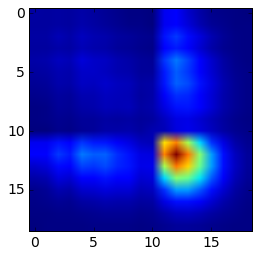

In [95]:
# Get chi2 arrays over the parameter space in nu and nubar mode
#  and find minima


gridZNuE=[]
for j in range(0,len(dm2)):
    gridZRow=[]
    for i in range(0,len(mix)):
        gridZRow.append(Chi2MBOscillated3p1Nu(dm2[j],mix[i]))
    print j
    gridZNuE.append(gridZRow)
minZNuE=min(numpy.array(gridZNuE).flatten())


gridZNuEBar=[]
for j in range(0,len(dm2)):
    gridZRow=[]
    for i in range(0,len(mix)):
        gridZRow.append(Chi2MBOscillated3p1NuBar(dm2[j],mix[i]))
    print j
    gridZNuEBar.append(gridZRow)
minZNuEBar=min(numpy.array(gridZNuEBar).flatten())



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


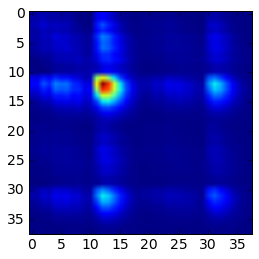

In [136]:

gridZNuEBarCombined=[]
for j in range(0,len(dm2)):
    gridZRowCombined=[]
    for i in range(0,len(mix)):
        gridZRowCombined.append(Chi2MBOscillated3p1Combined(dm2[j],mix[i]))
    print j
    gridZNuEBarCombined.append(gridZRowCombined)
minZNuEBarCombined=min(numpy.array(gridZNuEBarCombined).flatten())





In [137]:
#Find the best fits

minZSum=numpy.min(gridZNuEBarCombined)
argZsum=numpy.argmin(numpy.array(gridZNuEBarCombined).flatten())
argZnu=numpy.argmin(numpy.array(gridZNuE).flatten())
argZnubar=numpy.argmin(numpy.array(gridZNuEBar).flatten())

minXnu=gridX.flatten()[argZnu]
minYnu=gridY.flatten()[argZnu]
minXnubar=gridX.flatten()[argZnubar]
minYnubar=gridY.flatten()[argZnubar]
minXboth=gridX.flatten()[argZsum]
minYboth=gridY.flatten()[argZsum]



In [106]:
gridZNuE=numpy.array(gridZNuE,dtype=float)
gridZNuEBar=numpy.array(gridZNuEBar,dtype=float)



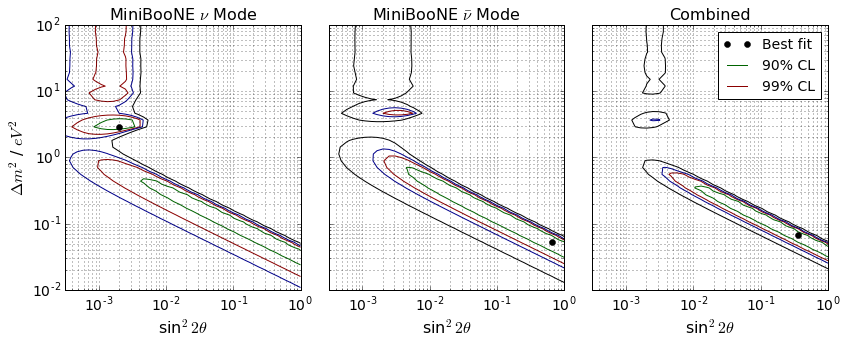

In [139]:
#Plot confidence intervals based on Wilks theorem for different samples

Cols=['DarkGreen','DarkRed','DarkBlue','black']

f, (ax1, ax2, ax3) =pylab.subplots(1,3,sharex=True, sharey=True,figsize=(12,5))
f.subplots_adjust(wspace=0)


CS = ax1.contour(gridX, gridY, (gridZNuE-minZNuE),levels=[2.3,4.6,6,9.21],colors=Cols)
ax1.plot(minXnu,minYnu,'o',color='black',label='Best fit')
ax1.plot([0,0],[0,0],color=Cols[0],label='90% CL')
ax1.plot([0,0],[0,0],color=Cols[1],label='99% CL')
#ax1.set_xlim(200,500)
ax1.loglog()
ax1.grid(which='both')
ax1.set_ylabel(r"$\Delta m^2$ / $eV^2$",fontsize=16)
ax1.set_xlabel(r"sin$^2\,2\theta$",fontsize=16)


ax1.set_title(r"MiniBooNE $\nu$ Mode",fontsize=16)

CS = ax2.contour(gridX, gridY, (gridZNuEBar-minZNuEBar),levels=[2.3,4.6,6,9.21],colors=Cols)
ax2.grid(which='both')
ax2.plot(minXnubar,minYnubar,'o',color='black',label='Best fit')
ax2.plot([0,0],[0,0],color=Cols[0],label='90% CL')
ax2.plot([0,0],[0,0],color=Cols[1],label='99% CL')
#ax2.set_xlim(200,500)
ax2.loglog()
ax2.set_xlabel(r"sin$^2\,2\theta$",fontsize=16)
ax2.set_title(r"MiniBooNE $\bar{\nu}$ Mode",fontsize=16)


CS = ax3.contour(gridX, gridY, gridZNuEBarCombined-minZNuEBarCombined,levels=[2.3,4.6,6,9.21],colors=Cols)
ax3.grid(which='both')
ax3.plot(minXboth,minYboth,'o',color='black',label='Best fit')
ax3.plot([0,0],[0,0],color=Cols[0],label='90% CL')
ax3.plot([0,0],[0,0],color=Cols[1],label='99% CL')
#ax3.set_xlim(200,500)
ax3.loglog()
ax3.legend(loc='upper right',fontsize=14)
ax3.set_xlabel(r"sin$^2\,2\theta$",fontsize=16)
ax3.set_title(r"Combined",fontsize=16)
f.subplots_adjust(wspace=0)

pylab.tight_layout()
pylab.savefig("FitPlots3p1.png",dpi=200,bbox_inches=0)

In [170]:
print "MiniBooNE best fits"
print Chi2MBOscillated3p1Nu(minYboth,minXboth)
print Chi2MBOscillated3p1NuBar(minYboth,minXboth)
print Chi2MBOscillated3p1Combined(minYboth,minXboth)



MiniBooNE best fits
18.8159615336
12.2653017039
37.3630736295


In [169]:
# https://arxiv.org/abs/1607.00011, PhysRevLett.117.221801
print "World best fits "
print Chi2MBOscillated3p1Nu(1.75,0.00145)
print Chi2MBOscillated3p1NuBar(1.75,0.00145)
print Chi2MBOscillated3p1Combined(1.75,0.00145)



World best fits 
25.5402119571
19.9443699913
52.5651868161


In [166]:
print "No Osc "
print Chi2MBOscillated3p1Nu(0,0)
print Chi2MBOscillated3p1NuBar(0,0)
print Chi2MBOscillated3p1Combined(0,0)



No Osc 
24.2267495306
23.4985806659
56.0145546367


In [19]:
# Print out the Chi2s
print "Neutrino Null:", Chi2MBOscillated(0,0,MBBinEdges,MBSimEvents,MBBackground,MBCounts)
print "Antineutrino Null:", Chi2MBOscillated(0,0,MBBinEdges,MBSimEvents_an,MBBackground_an,MBCounts_an)
print "Neutrino BF:", minZNuE
print "AntiNeutrino BF:", minZNuEBar
print "Both BF:",minZSum

Neutrino Null: 55.2466949178
Antineutrino Null: 28.9736859717
Neutrino BF: 11.4196991148
AntiNeutrino BF: 4.6629351984
Both BF: 16.0901417804
